# Final Exam CPSC 8420 - Fall 2024
## Mohammad Alshurbaji
## Dr. Kai Lu

# The Required Packages

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt 
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge 
from sklearn.decomposition import PCA
import time
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import rbf_kernel, linear_kernel
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans

plt.figure(figsize=(14, 10))

<Figure size 1400x1000 with 0 Axes>

<Figure size 1400x1000 with 0 Axes>

# Problem 1: Lasso Problem
Implementing Coordination Minimization for Lasso Problem to prove that when lamba equal the specifid term, then B is zero

In [2]:
# Generate the variables
np.random.seed(0)
X = np.random.rand(20, 10)
y = np.random.rand(20)

# Set Lambda to the specified condition: λ ≥ ∥X^T y∥∞
lambd = np.max(np.abs(X.T @ y))
print(f"The value of Lambda is: {lambd:.2f}")

# Define the soft-thresholding function
def soft_threshold(b, lambd):
    if b > lambd:
        return b - lambd
    elif b < -lambd:
        return b + lambd
    else:
        return 0

# Lasso Coordinate Descent
def lasso_coordinate_min(A, y, lambd, iterations=1000, tol=1e-8):
    x = np.zeros(A.shape[1])  # Initialize with zeros
    b = 2 * A.T @ y
    a = A.T @ A
    
    for iteration in range(iterations):
        x_old = x.copy()  # Store old value for convergence check
        
        for j in range(A.shape[1]):
            residual = y - A @ x + x[j] * A[:, j]
            rho = A[:, j].T @ residual
            x[j] = soft_threshold(rho, lambd) / a[j, j]
        
        # Check for convergence using infinity norm
        if np.linalg.norm(x - x_old, ord=np.inf) < tol:
            break

    return x

# Find the optimal value
B_star = lasso_coordinate_min(X, y, lambd)
print(f"Lambda: {lambd:.2f}, Solution B_star_coordinate_descent: {B_star}")

#Now implementing using the sklearn
B_star_sklearn = []
lasso = Lasso(alpha=lambd, max_iter=1000,tol=1e-6)
B_star_sklearn = lasso.fit(X, y)
print(f"Lambda: {lambd:.2f}, Solution B_star_sklearn: {lasso.coef_}")

The value of Lambda is: 5.82
Lambda: 5.82, Solution B_star_coordinate_descent: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Lambda: 5.82, Solution B_star_sklearn: [-0. -0. -0.  0. -0. -0.  0. -0. -0. -0.]


# Problem 3: Principle Components Analysis (PCA)
## Please find USArrests dataset online and:
• Implement your own program to reproduce the image on page 16/26 of ‘PCA’ slides on Canvas
(if yours is flipped up and down, (or) left and right from the slide, it is totally Okay).

In [39]:
#Downloading the Dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("halimedogan/usarrests")

print("Path to dataset files:", path)

100%|██████████| 960/960 [00:00<00:00, 19.9kB/s]

Extracting files...


Path to dataset files: /home/malshur/.cache/kagglehub/datasets/halimedogan/usarrests/versions/1


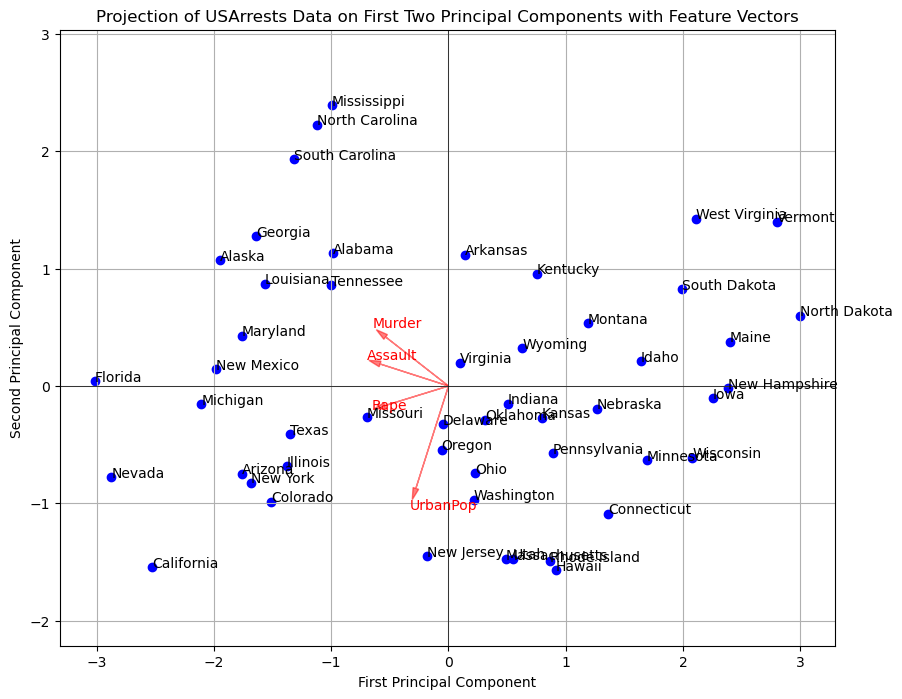

In [3]:
dataset = pd.read_csv('/home/malshur/.cache/kagglehub/datasets/halimedogan/usarrests/versions/1/USArrests.csv')
# print(dataset.head())
# # print(dataset.iloc[:,1:])
# print(dataset.iloc[:,0])
# # Step 1: Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(dataset.iloc[:,1:])
features = dataset.columns[1:]  # Extract feature names (Murder, Assault, UrbanPop, Rape)

# Step 2: SVM
U, Sigma, VT = np.linalg.svd(X, full_matrices=False)
k = 2
U_k = U[:, :k]
Sigma_k = Sigma[:k]
VT_k = VT[:k, :]
# Step 3: Projection Matrix W:
W = VT_k.T
#Step 4: Transform the data to subspace Y
Y = X.dot(W)
#Step5: Visualization
plt.figure(figsize=(10, 8))
plt.scatter(Y[:, 0], Y[:, 1], c='blue', marker='o')

# State names
for i, txt in enumerate(dataset.iloc[:,0]):
    plt.annotate(txt, (Y[i, 0], Y[i, 1]))

# Feature vectors
for i in range(4):
    plt.arrow(0, 0, VT_k[0, i], VT_k[1, i], color='red', alpha=0.5, head_width=0.05, head_length=0.1)
    plt.text(VT_k[0, i] * 1.2, VT_k[1, i] * 1.2, features[i], color='red')

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Projection of USArrests Data on First Two Principal Components with Feature Vectors')
plt.grid(True)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.axis('equal')  # Ensure that the unit scales are equal along both axes
plt.show()

# Problem 3 - Section 2: Data Completion
Luckily, this is kinda the same idea of my final project. Implementing Data Completion using Proximal Gradient Descent Method - Nuclier Norm. 

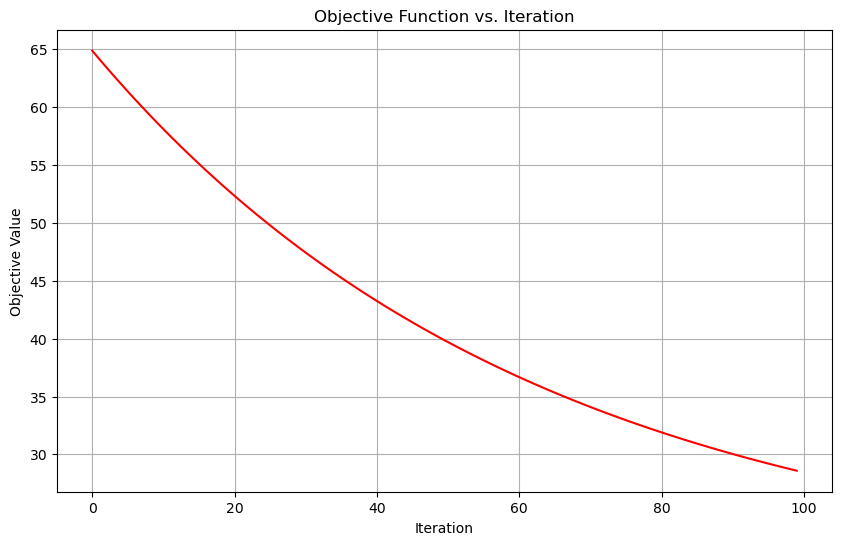

In [4]:
# Starting with the mask
def create_random_mask(X):
    mask = np.ones_like(X, dtype=bool)
    for i in range(X.shape[0]):
        random_feature = np.random.choice(X.shape[1])
        mask[i, random_feature] = False
    return mask

mask = create_random_mask(X)
X_masked = np.copy(X)
X_masked[~mask] = 0  # Replace missing values with 0s in the masked dataset

# Proximal gradient descent variables
Z = np.zeros_like(X_masked)
lambd = 1.0  
alpha = 1 / (np.linalg.norm(X, ord=2)**2)  # Learning rate based on Lipschitz constant

# Define nuclear norm and objective function
def nuclear_norm(Z):
    return np.sum(np.linalg.svd(Z, compute_uv=False))

def objective_function(X, Z, mask, lambd):
    diff = mask * (X - Z)
    return 0.5 * np.linalg.norm(diff, 'fro')**2 + lambd * nuclear_norm(Z)

# Proximal gradient descent
iterations = 100
obj_values = []

for i in range(iterations):
    gradient = mask * (Z - X) 
    Z -= alpha * gradient
    
    U, S, VT = np.linalg.svd(Z, full_matrices=False)
    S = np.maximum(S - alpha * lambd, 0)  # Shrinkage on singular values
    Z = U @ np.diag(S) @ VT

    obj_value = objective_function(X, Z, mask, lambd)
    obj_values.append(obj_value)
#Visualization
plt.figure(figsize=(10, 6))
plt.plot(range(iterations), obj_values, color='r')
plt.xlabel('Iteration')
plt.ylabel('Objective Value')
plt.title('Objective Function vs. Iteration')
plt.grid(True)
plt.show()

# Problem 4: Spectral Clustering
Please reproduce Figure (14.29) in The Elements of Statistical Learning with your own codes. You
are NOT allowed to call ‘spectral clustering’ function built-in python or matlab.
## P.S. Since I don't have the dataset, I generated the dataset based on the critiria written under the figure description.

/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


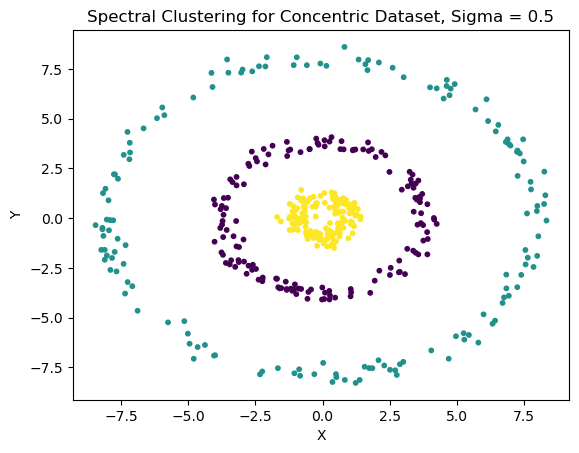

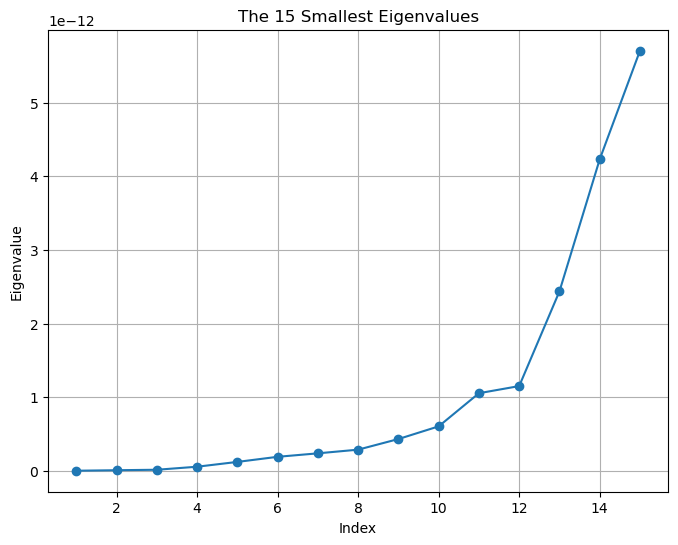

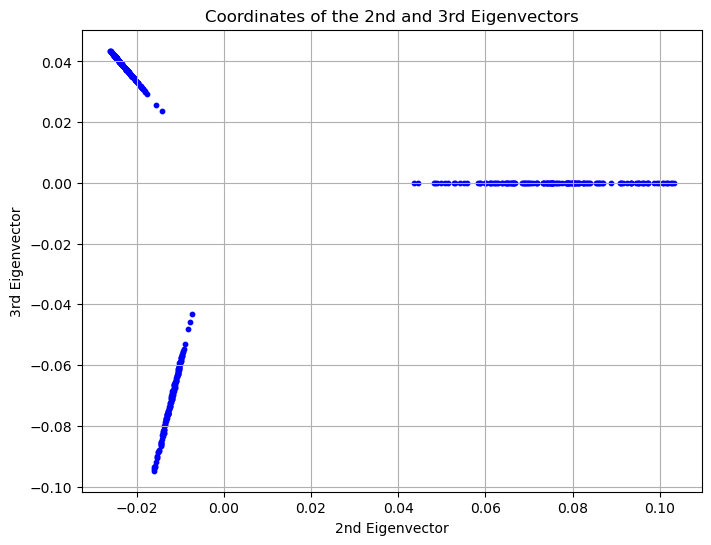

In [5]:
# Generate the Dataset
n_cluster = 150
std_dev = 0.25  
radii = [1, 3.8, 8]
data = []
labels = []

for idx, radius in enumerate(radii):
    angles = np.random.uniform(0, 2 * np.pi, n_cluster)
    x = radius * np.cos(angles) + np.random.normal(0, std_dev, n_cluster)
    y = radius * np.sin(angles) + np.random.normal(0, std_dev, n_cluster)
    data.append(np.column_stack((x, y)))
    labels.extend([idx] * n_cluster)

data = np.vstack(data)
labels = np.array(labels)

# Defining the required Functions for the Spectral Clustering
def construct_affinity_matrix(data, sigma):
    Pdistance = squareform(pdist(data, 'euclidean'))
    affinity_matrix = np.exp(-Pdistance**2 / (2 * sigma**2))  # Gaussian Kernel
    return affinity_matrix

def symmetrically_normalize(affinity_matrix):
    dmatrix = np.sum(affinity_matrix, axis=1)
    symmetrical_normalize = affinity_matrix / np.sqrt(np.outer(dmatrix, dmatrix))
    return symmetrical_normalize

# Spectral Clustering
def spectral_clustering(data, k, sigma):
    # Constructing the affinity matrix
    affinity_matrix = construct_affinity_matrix(data, sigma)
    # Symmetrical Normalization
    normalized_affinity = symmetrically_normalize(affinity_matrix)
    # Eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(normalized_affinity)
    # Extract the k largest eigenvectors
    top_k_eigenvectors = eigenvectors[:, -k:]
    # Normalize rows of eigenvectors
    norms = np.linalg.norm(top_k_eigenvectors, axis=1, keepdims=True)
    normalized_eigenvectors = top_k_eigenvectors / norms
    # K-means
    kmeans = KMeans(n_clusters=k, random_state=0)
    clusters = kmeans.fit_predict(normalized_eigenvectors)
    return clusters, eigenvalues, eigenvectors

# Plotting the clusters
def plot_clusters(data, clusters, title):
    plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='viridis', s=10)
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

# Plotting the smallest eigenvalues
def plot_smallest_eigenvalues(eigenvalues):
    sorted_eigenvalues = np.sort(eigenvalues)
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, 16), sorted_eigenvalues[:15], '-o')
    plt.title('The 15 Smallest Eigenvalues')
    plt.xlabel('Index')
    plt.ylabel('Eigenvalue')
    plt.grid(True)
    plt.show()

# Plotting the 2nd and 3rd eigenvectors
def plot_eigenvectors_2nd_3rd(data, eigenvectors):
    second_eigenvector = eigenvectors[:, -2]  # 2nd largest eigenvector
    third_eigenvector = eigenvectors[:, -3]   # 3rd largest eigenvector
    plt.figure(figsize=(8, 6))
    plt.scatter(second_eigenvector, third_eigenvector, c='blue', s=10)
    plt.title('Coordinates of the 2nd and 3rd Eigenvectors')
    plt.xlabel('2nd Eigenvector')
    plt.ylabel('3rd Eigenvector')
    plt.grid(True)
    plt.show()

# Implementing the Algorithm
sigma = 0.5
k = 3
clusters, eigenvalues, eigenvectors = spectral_clustering(data, k, sigma)

# Plot clusters
plot_clusters(data, clusters, f'Spectral Clustering for Concentric Dataset, Sigma = {sigma}')

# Plot the 15 smallest eigenvalues
plot_smallest_eigenvalues(eigenvalues)

# Plot the 2nd and 3rd eigenvectors
plot_eigenvectors_2nd_3rd(data, eigenvectors)


# Problem 5: Logistic Regression (Binary Classification)
## Section 1: Gradient Descent Method
Comparing between the two objective functions where the labels are either {1,-1} or {0,1} and prove that they have the same results using Gradient Descent Method.
P.S. The step size will be set optimally using liptchitz: step_size = 1/L; where L is the Largest Singular Value

Optimal weights for {-1, +1} labels: [ 0.042408    0.23240133 -1.1810531  -1.25847384  0.4874669  -1.25579434
  0.54439335  1.18239953 -1.1830707   1.12690954  0.8979149   1.11270855
 -0.08327913 -1.39293881  0.60320726 -0.08946655 -1.18666548 -0.57306619
 -0.19103324  0.59600291 -0.04543907  0.37930383 -0.00282008 -0.94072333
 -0.12771843  1.47678189 -0.79027048  0.69669515 -1.1039499   1.38385688
  0.48988999  1.02084025  1.49700437  0.05211528 -0.35192628 -2.08077771
 -0.60029861 -1.51015007  0.92420381 -0.59126904 -1.28855286  0.45458957
 -0.51200967  0.97326459 -0.21736568  0.48550173  1.79010648 -0.06314249
 -0.75199454  0.77588084 -0.27300714  0.2213608   1.45195533 -0.74403178
 -0.60482362 -0.46519235 -0.48511529  0.13385644 -0.35583667 -1.22647189
 -1.4522757   1.16293138  0.39298131 -0.11888213 -0.19680833 -0.20208821
 -0.90698353 -0.10047502 -0.1667258  -0.35796705  0.28377695 -0.75863876
 -2.03965961 -0.11065166 -0.06187024  0.84341388  0.4107217  -2.08509402
  0.48475769 -

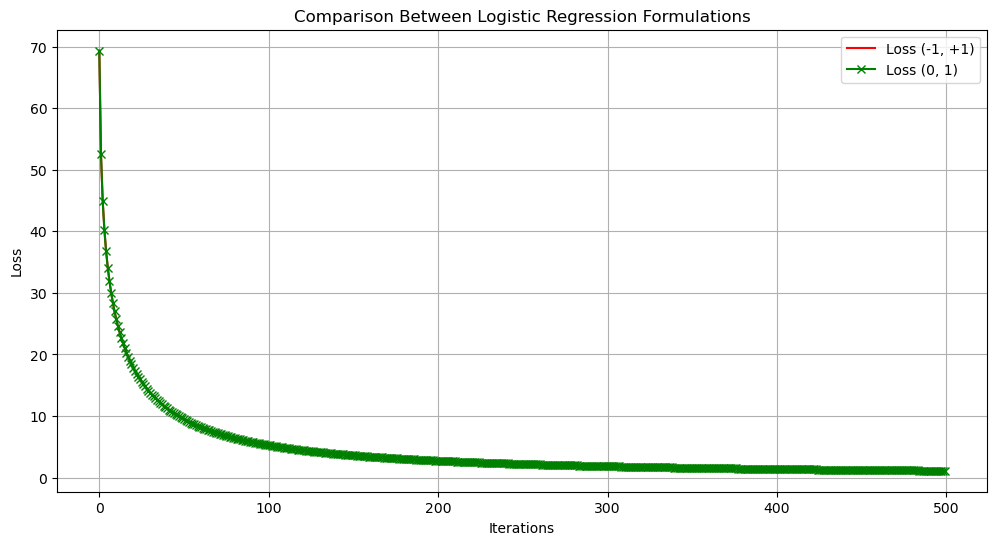

In [7]:
#Generate the Dataset
np.random.seed(0)
m, d = 100, 100
X  =np.random.randn(m,d)
w_0 = np.zeros(d)
y_1 = np.random.choice([-1,1], size = m) # Labels are {-1,1}
y_0 = (y_1 == 1).astype(float) # convert the labels to {0,1}

#Logistic Regression Objectives
def logistic_loss_1(w, X, y):
    "labels in {-1, +1}"
    return np.sum(np.log(1 + np.exp(-y * (X @ w))))

def logistic_loss_0(w, X, y):
    "labels in {0, 1}"
    return np.sum(np.log(1 + np.exp(X @ w)) - y * (X @ w))

#Gradients
def gradient_1(w, X, y):
    "For labels in {-1, +1}"
    exp_1 = np.exp(-y * (X @ w))
    return -np.sum((y[:, None] * X) * (exp_1 / (1 + exp_1))[:, None], axis=0)

def gradient_0(w, X, y):
    "For labels in {0, 1}"
    exp_0= np.exp(X @ w)
    return np.sum((X * (exp_0/ (1 + exp_0))[:, None]) - (y[:, None] * X), axis=0)

# Gradient Descent Method
def gradient_descent(X, y, loss_func, grad_func, steps, step_size):
    w = w_0.copy()
    losses = []
    for _ in range(steps):
        loss = loss_func(w, X, y)
        losses.append(loss)
        grad = grad_func(w, X, y)
        w -= step_size * grad  
    return w, losses

#Step Size using Liptchitz
spectral_norm = np.linalg.norm(X, ord=2)  
step_size = 4 / (spectral_norm**2)

#Implementing Gradient Descent Method:
steps = 500
w_1, losses_1, = gradient_descent(X, y_1, logistic_loss_1, gradient_1, steps, step_size)
w_0, losses_0, = gradient_descent(X, y_0, logistic_loss_0, gradient_0, steps, step_size)

#Comparison
print("Optimal weights for {-1, +1} labels:", w_1)
print("Optimal weights for {0, 1} labels:", w_0)
print("Difference between optimal weights:", np.linalg.norm(w_1 - w_0))

#Visualization
plt.figure(figsize=(12, 6))
plt.plot(losses_1, label="Loss (-1, +1)", color="red")
plt.plot(losses_0, label="Loss (0, 1)",color="green", marker = 'x')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Comparison Between Logistic Regression Formulations")
plt.legend()
plt.grid(True)
plt.show()


# Problem 5: Logistic Regression (Binary Classification)
## Section 3: Newton method Method 
Implementing Newton method and compare it with gradient descent method( Constant step size).
P.S. Newton Method: uses both first and second derivatives in its decisions. 

/local_scratch/slurm.1356723/ipykernel_423609/4161804006.py:16: RuntimeWarning: overflow encountered in exp
  return np.sum(np.log(1 + np.exp(X @ w)) - y * (X @ w))
/local_scratch/slurm.1356723/ipykernel_423609/4161804006.py:26: RuntimeWarning: overflow encountered in exp
  exp_0= np.exp(X @ w)
/local_scratch/slurm.1356723/ipykernel_423609/4161804006.py:27: RuntimeWarning: invalid value encountered in divide
  return np.sum((X * (exp_0/ (1 + exp_0))[:, None]) - (y[:, None] * X), axis=0)


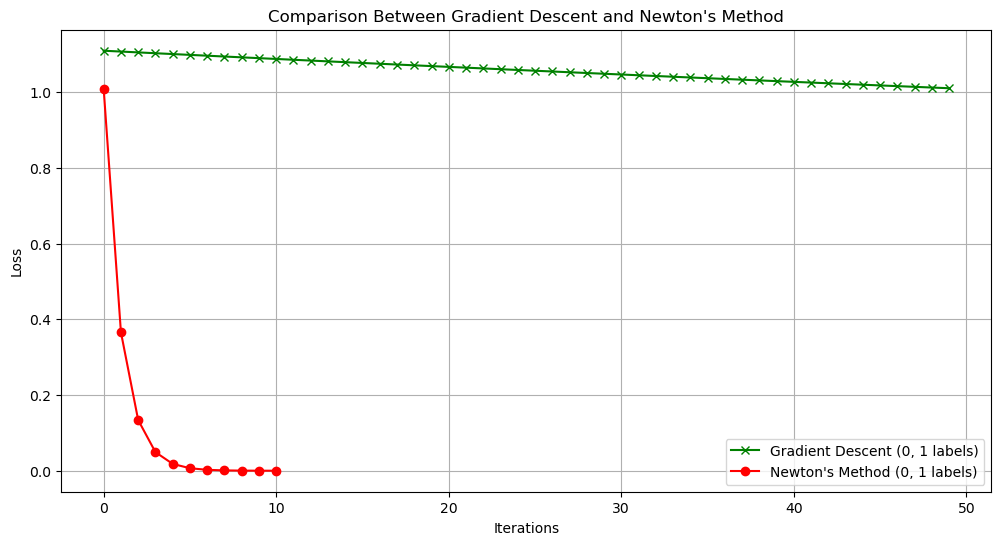

In [8]:
# Hessian_0: Newton's where {0,1}
def hessian_0(w, X, y):
    z = X @ w
    p = 1 / (1 + np.exp(-z))  
    diag = p * (1 - p)  
    H = X.T @ (diag[:, None] * X)  
    return H

# Newton's Method
def newton_method(X, y, loss_func, grad_func, hess_func, steps):
    w = w_0.copy()
    losses = []
    for _ in range(steps):
        loss = loss_func(w, X, y)
        losses.append(loss)
        grad = grad_func(w, X, y)
        H = hess_func(w, X, y)
        w -= np.linalg.solve(H, grad)  # Update rule
    return w, losses

# Implementing Gradient Descent Method:
steps = 50
w_0, losses_0 = gradient_descent(X, y_0, logistic_loss_0, gradient_0, steps, step_size)

# Implementing Newton's Method:
w_newton_0, losses_newton_0 = newton_method(X, y_0, logistic_loss_0, gradient_0, hessian_0, steps)

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(range(steps), losses_0, label="Gradient Descent (0, 1 labels)", color="green", marker = 'x')
plt.plot(range(steps), losses_newton_0, label="Newton's Method (0, 1 labels)", color="red", marker='o')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Comparison Between Gradient Descent and Newton's Method")
plt.legend()
plt.grid(True)
plt.show()

# Problem 5: Logistic Regression (Binary Classification)
## Section 4: Stochastic Gradient Descent Method (SGD)
The difference between SGD and GDM is that we update the model's parameters using a single sample or a mini batch of data at each step, rather than the entire dataset. Which makes it cheaper and faster for large datasets, but more noisy (slower convergence).

Running experiments for dataset size m = 100...


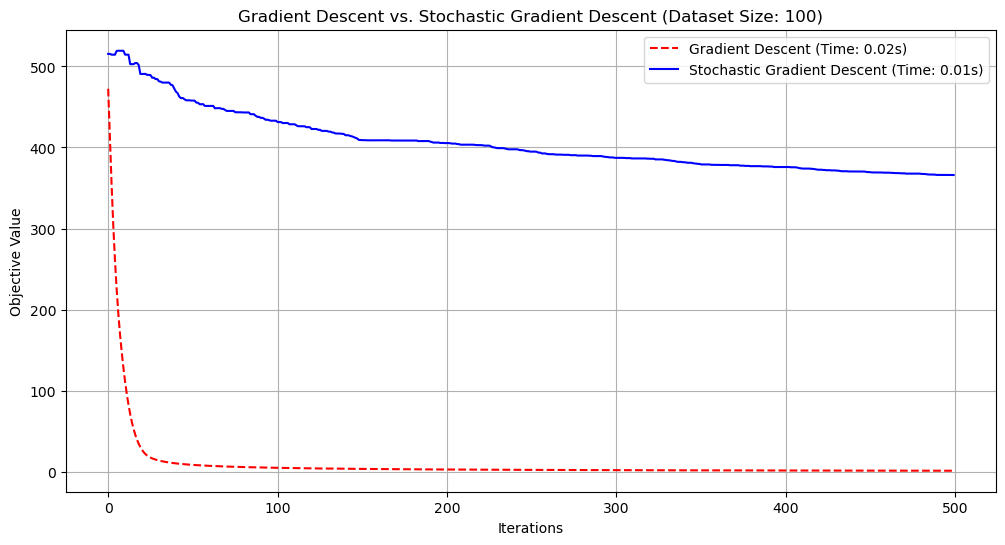

Running experiments for dataset size m = 1000...


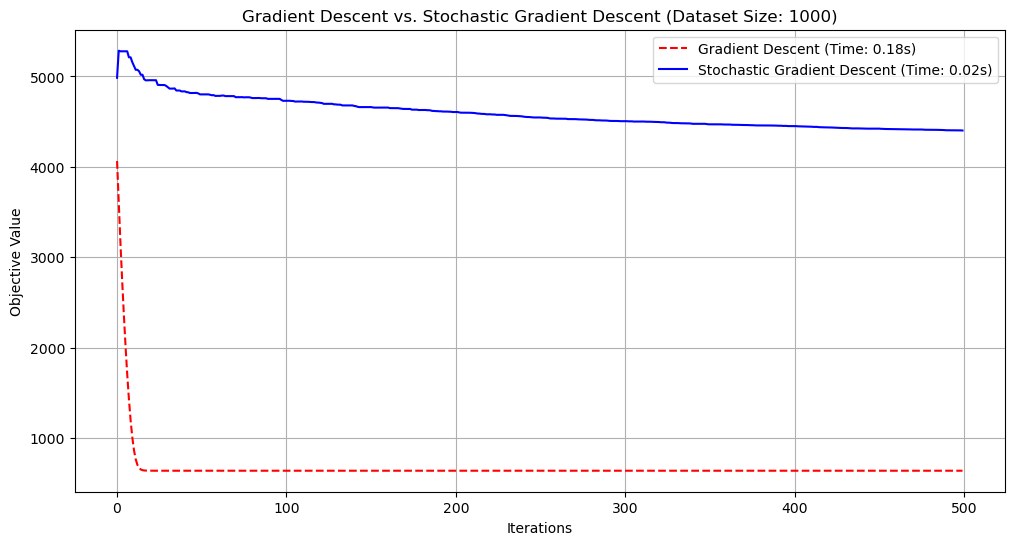

Running experiments for dataset size m = 10000...


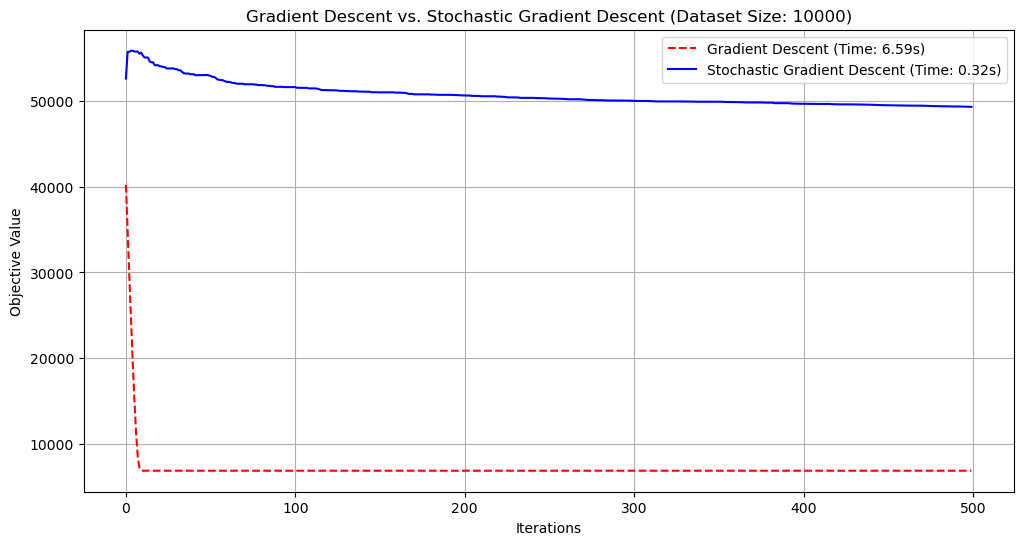

Running experiments for dataset size m = 100000...


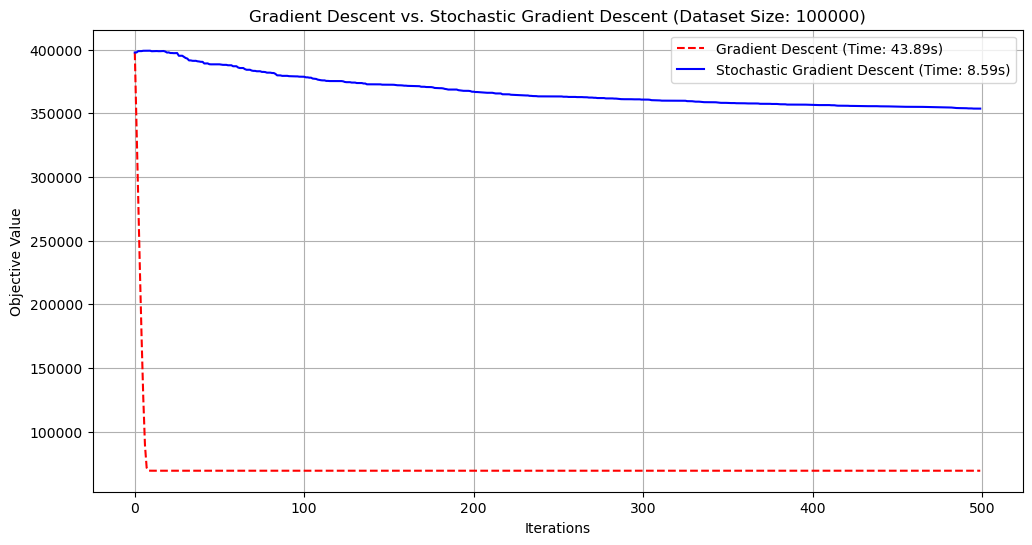

In [14]:
# Stochastic Gradient Descent Method
def stochastic_gradient_descent(X, y, loss_func, steps):
    w = w_0.copy()
    losses = []
    for t in range(steps):
        i = np.random.randint(0, len(y))  
        x_i, y_i = X[i], y[i]
        z = x_i @ w
        p = 1 / (1 + np.exp(-z))  
        grad = (p - y_i) * x_i  
        step_size = 1 / (t + 1)  
        w -= step_size * grad
        loss = loss_func(w, X, y) 
        losses.append(loss)
    return w, losses

# Dataset Generation
def generate_dataset(m, d=100):
    X = np.random.randn(m, d)  
    y = np.random.choice([0, 1], size=m)  
    return X, y

# Experiment Settings
dataset_sizes = [100, 1000, 10000, 100000]  
steps = 500  
results = {}

# Run Experiments
for m in dataset_sizes:
    print(f"Running experiments for dataset size m = {m}...")
    
    # Generate dataset
    X, y = generate_dataset(m)
    
    # Step size for Gradient Descent
    spectral_norm = np.linalg.norm(X, ord=2) 
    step_size = 4 / (spectral_norm**2)
    
    # Gradient Descent
    start_time = time.time()
    w_gd_0, losses_gd_0 = gradient_descent(X, y, logistic_loss_0, gradient_0, steps, step_size)
    gd_time = time.time() - start_time
    
    # Stochastic Gradient Descent
    start_time = time.time()
    w_sgd_0, losses_sgd_0 = stochastic_gradient_descent(X, y, logistic_loss_0, steps)
    sgd_time = time.time() - start_time
    
    # Store Results
    results[m] = {
        "losses_gd": losses_gd_0,
        "gd_time": gd_time,
        "losses_sgd": losses_sgd_0,
        "sgd_time": sgd_time,
    }
    # Plot for this dataset size
    plt.figure(figsize=(12, 6))
    plt.plot(
        range(steps),
        losses_gd_0,
        label=f"Gradient Descent (Time: {gd_time:.2f}s)",
        linestyle="--",
        color="red"
    )
    plt.plot(
        range(steps),
        losses_sgd_0,
        label=f"Stochastic Gradient Descent (Time: {sgd_time:.2f}s)",
        linestyle="-",
        color="blue"
    )
    plt.xlabel("Iterations")
    plt.ylabel("Objective Value")
    plt.title(f"Gradient Descent vs. Stochastic Gradient Descent (Dataset Size: {m})")
    plt.legend()
    plt.grid(True)
    plt.show()
   


# Problem 6: Kernel SVM
In this problem we're requested to count the support vectors for each of the 3 SVMs. We're required to work with Iris Dataset.

In [15]:
# Load the Iris dataset
iris = datasets.load_iris()
X = iris.data  # Features
y = iris.target  # Labels

# kernel: K = K1 + K2
def custom_kernel(X, Y):
    gamma = 1  
    K1 = rbf_kernel(X, Y, gamma=gamma)  # Gaussian kernel
    K2 = linear_kernel(X, Y)  # Linear kernel
    return K1 + K2

# One-vs-One classification
class_pairs = [(0, 1), (0, 2), (1, 2)]
support_vectors = {}

for pair in class_pairs:
    print(f"Training SVM for class pair {pair}...")
    X_pair = X[np.logical_or(y == pair[0], y == pair[1])]
    y_pair = y[np.logical_or(y == pair[0], y == pair[1])]
    
    # Binary (-1, 1) for the SVM
    y_pair = np.where(y_pair == pair[0], -1, 1)
    
    # Training
    svm = SVC(kernel=custom_kernel, C=1)
    svm.fit(X_pair, y_pair)
    
    # Counting 
    n_support_vectors = svm.n_support_
    support_vectors[pair] = n_support_vectors
    print(f"Number of support vectors for class pair {pair}: {n_support_vectors}")

# Conclusion
print("\nSupport Vector Summary:")
for pair, n_support in support_vectors.items():
    print(f"Class pair {pair}: {n_support} support vectors (total: {sum(n_support)})")


Training SVM for class pair (0, 1)...
Number of support vectors for class pair (0, 1): [4 1]
Training SVM for class pair (0, 2)...
Number of support vectors for class pair (0, 2): [4 2]
Training SVM for class pair (1, 2)...
Number of support vectors for class pair (1, 2): [10  9]

Support Vector Summary:
Class pair (0, 1): [4 1] support vectors (total: 5)
Class pair (0, 2): [4 2] support vectors (total: 6)
Class pair (1, 2): [10  9] support vectors (total: 19)
